<a href="https://colab.research.google.com/github/JoeyMucci/SemanticSegmentationSatelliteImagery/blob/main/ModelComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Originally from DigitalSreeni https://youtu.be/jvZm8REF2KY
import os
import cv2
import numpy as np

!pip install patchify 
!pip install segmentation-models 
import tensorflow
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from keras.metrics.metrics import PrecisionAtRecall

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/'

patch_size = 256

# Read images into patches and crop
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    subdirs.sort(); # sort the subdirectory so the images and masks match
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = os.listdir(path)  # list of all image names in this subdirectory
        images.sort() # sort the images so they match with the masks
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):              
                image = cv2.imread(path+"/"+image_name, 1)  

                # get the highest size divisble than 256 but less than the original size
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 

                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  # crop from top left corner
                image = np.array(image)             
       
                # extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0] # drop the extra unecessary dimension that patchify adds                         
                        image_dataset.append(single_patch_img)
                
# Read corresponding masks into patches and crop
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    subdirs.sort();
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   
        masks = os.listdir(path)  # list of all mask names in this subdirectory
        masks.sort(); # sort the masks so they match with the images
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):     
                mask = cv2.imread(path+"/"+mask_name, 1)  
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)

                # get the highest size divisble than 256 but less than the original size
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 

                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)             
       
                # extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size) 
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] # drop the extra unecessary dimension that patchify adds                             
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

# Convert HEX to RGB array
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Converts an RGB value to an integer label
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 
# Get categorical labels
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666] # 1/6 = 0.1666
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) # loss functoin is sum of dice loss and focal loss  

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

path_m = '/content/drive/MyDrive/ColabNotebooks/'
import sys
sys.path.insert(0,path_m)
import simple_multi_unet_model
from simple_multi_unet_model import multi_unet_model, jacard_coef  

recall = [item / 100 for item in range(1, 100)] # Generate range of recall values (0.01-0.99)
metrics = []
for recallVal in recall:
  metrics.append(PrecisionAtRecall(recall = recallVal)) # Define a list of metrics as precision values at a corresponding recall value

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

# Old model
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

# Model with optimized hyperparameters
history2 = model.fit(X_train, y_train, 
                    batch_size = 2, 
                    validation_batch_size = 29,
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Segmentation Models: using `keras` framework.
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segme

1/1 [==============================] - 0s 22ms/step
10th most accurate image. Accuracy is 85.52%
1/1 [==============================] - 0s 20ms/step


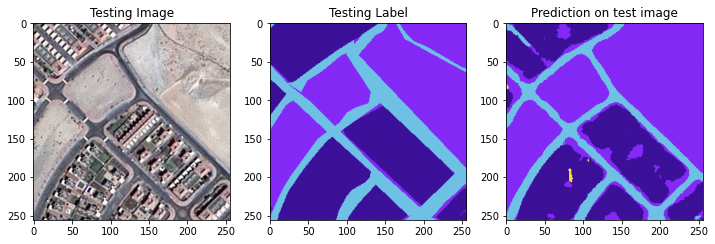

9th most accurate image. Accuracy is 85.82%
1/1 [==============================] - 0s 18ms/step


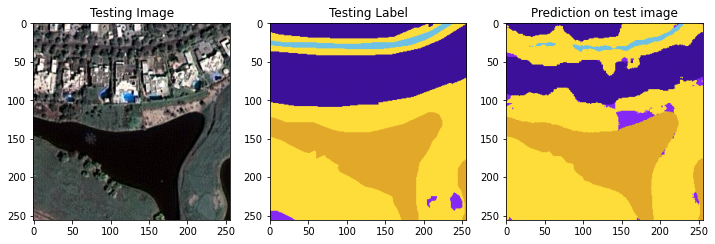

8th most accurate image. Accuracy is 86.57%
1/1 [==============================] - 0s 19ms/step


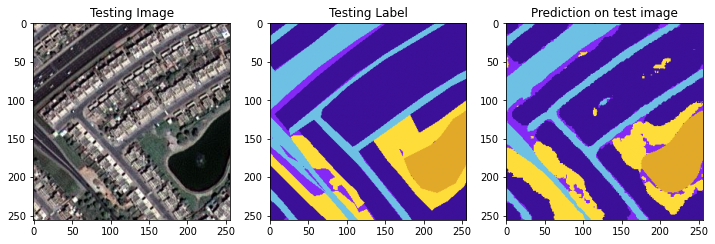

7th most accurate image. Accuracy is 86.72%
1/1 [==============================] - 0s 20ms/step


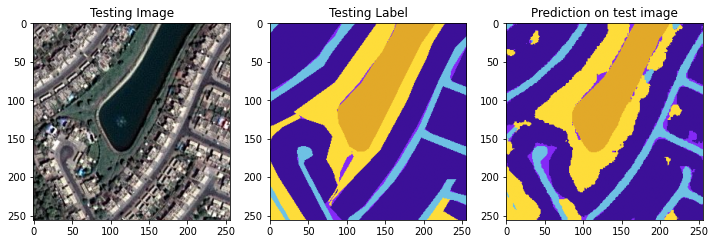

6th most accurate image. Accuracy is 86.75%
1/1 [==============================] - 0s 18ms/step


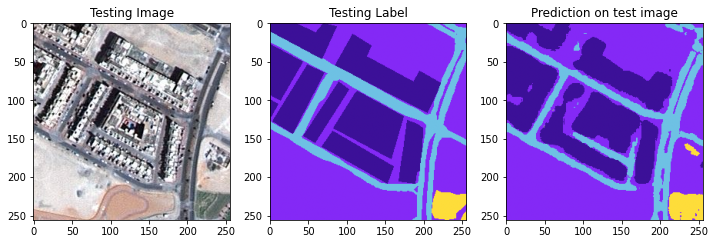

5th most accurate image. Accuracy is 87.10%
1/1 [==============================] - 0s 20ms/step


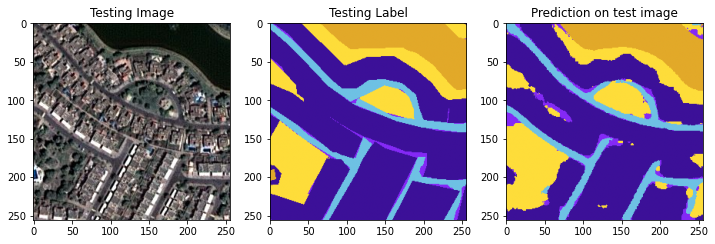

4th most accurate image. Accuracy is 87.16%
1/1 [==============================] - 0s 18ms/step


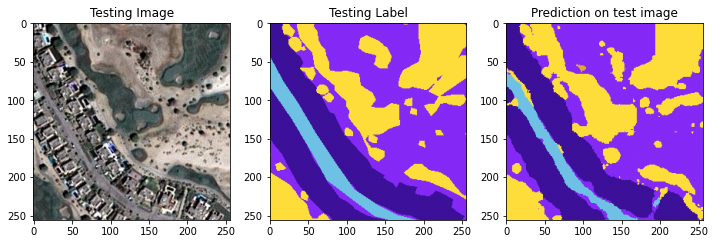

3rd most accurate image. Accuracy is 87.34%
1/1 [==============================] - 0s 18ms/step


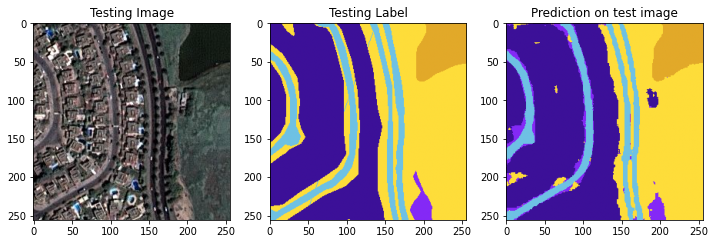

2nd most accurate image. Accuracy is 87.85%
1/1 [==============================] - 0s 20ms/step


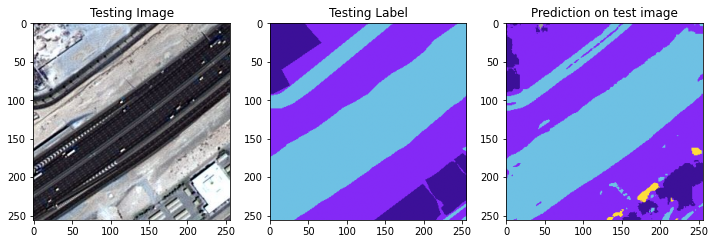

Most accurate image. Accuracy is 89.02%
1/1 [==============================] - 0s 20ms/step


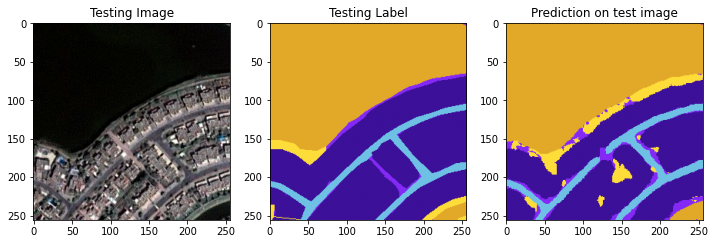

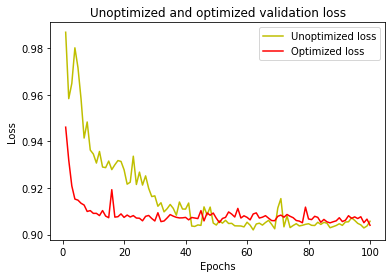

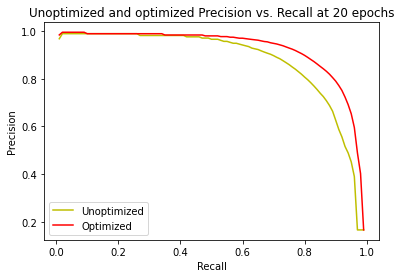

In [39]:
# IOU (intersection over union)
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

# Recolors the images to the original color scheme for easier comprehension
def recolor(old):
  new=np.zeros((256, 256, 3))
  for row in range(256):
    for col in range(256): 
      if(old[row][col] == 0): # Building (Dark Purple)
        new[row][col][0] = 60 / 255
        new[row][col][1] = 16 / 255
        new[row][col][2] = 152 / 255
      elif(old[row][col] == 1): # Land (Bright Purple)
        new[row][col][0] = 132 / 255
        new[row][col][1] = 41 / 255
        new[row][col][2] = 246 / 255
      elif(old[row][col] == 2): # Road (Cyan)
        new[row][col][0] = 110 / 255
        new[row][col][1] = 193 / 255
        new[row][col][2] = 228 / 255
      elif(old[row][col] == 3): # Vegetation (Yellow)
        new[row][col][0] = 254 / 255
        new[row][col][1] = 221 / 255
        new[row][col][2] = 58 / 255
      elif(old[row][col] == 4): # Water (Orange)
        new[row][col][0] = 226 / 255
        new[row][col][1] = 169 / 255
        new[row][col][2] = 41 / 255
      else: # Unlabeled (Gray)
        new[row][col][0] = 155 / 255
        new[row][col][1] = 155 / 255
        new[row][col][2] = 155 / 255
  return new;

# Return what percentage of the pixels are accurately matched
def accuracy(truth, guess):
  correct = 0
  for row in range(256):
    for col in range(256): 
      if truth[row][col][0] == guess[row][col][0]:
        correct += 1
  return correct / (256 ** 2)

# Returns whether or not the image is "mixed".
# There must be a variety of different classes in a reasonable
# distribution (i.e. the image is not dominated by one class).
def ismixed(truth):
  bld, lnd, rd, veg, wat, un = 0, 0, 0, 0, 0, 0
  for row in range(256):
    for col in range(256): 
      if truth[row][col][0] == 60 / 255:
        bld += 1
      elif truth[row][col][0] == 132 / 255:
        lnd += 1
      elif truth[row][col][0] == 110 / 255:
        rd += 1
      elif truth[row][col][0] == 254 / 255:
        veg += 1
      elif truth[row][col][0] == 226 / 255:
        wat += 1
      else: un += 1

  counts = [bld, lnd, rd, veg, wat, un]
  for i in range(len(counts)):
    counts[i] /= (256 ** 2)
  inequality = 0
  for count in counts:
    inequality += count ** 2
  return inequality <= .4

# Show 10 best nontrivial predictions
accstoinds = {} # map of accuracies to indices
for i in range(len(X_test)):
  test_img = X_test[i]
  ground_truth=y_test_argmax[i]
  ground_truth_recolor = recolor(ground_truth)
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  predicted_img_recolor = recolor(predicted_img)
  if not ismixed(ground_truth_recolor):
    continue
  if len(accstoinds) < 10 or accuracy(ground_truth_recolor, predicted_img_recolor) > min(accstoinds.keys()):
    accstoinds[accuracy(ground_truth_recolor, predicted_img_recolor)] = i
    if(len(accstoinds) == 11):
      minacc = min(accstoinds.keys())
      accstoinds.pop(minacc)

accstoinds = sorted(accstoinds.items())
i = 0
for key, value in accstoinds:
  if 10 - i >= 4:
    print(f"{10-i}th most accurate image. Accuracy is{key * 100 : .2f}%")
  elif 10 - i == 3:
    print(f"{10-i}rd most accurate image. Accuracy is{key * 100 : .2f}%")
  elif 10 - i == 2:
    print(f"{10-i}nd most accurate image. Accuracy is{key * 100 : .2f}%")
  else: print(f"Most accurate image. Accuracy is{key * 100 : .2f}%")
  test_img = X_test[value]
  ground_truth=y_test_argmax[value]
  ground_truth_recolor = recolor(ground_truth)
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  predicted_img_recolor = recolor(predicted_img)
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth_recolor)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img_recolor)
  plt.show()
  i += 1

# Plot optimized and unoptimized validation accuracy as a function of epochs
reg_loss = history1.history['val_loss']
opt_loss = history2.history['val_loss']
epochs = range(1, len(reg_loss) + 1)
plt.plot(epochs, reg_loss, 'y', label='Unoptimized loss')
plt.plot(epochs, opt_loss, 'r', label='Optimized loss')
plt.title('Unoptimized and optimized validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot precision vs recall values for both training and validation sets
reg_precision = [history1.history['val_precision_at_recall'][-1]]
opt_precision = [history2.history['val_precision_at_recall'][-1]]
for i in range(1, 99):
  reg_precision.append(history1.history['val_precision_at_recall_' + str(i)][19])
  opt_precision.append(history2.history['val_precision_at_recall_' + str(i)][19])
plt.plot(recall, reg_precision, 'y', label = "Unoptimized")
plt.plot(recall, opt_precision, 'r', label = "Optimized")
plt.title("Unoptimized and optimized Precision vs. Recall at 20 epochs")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()